(rois:saving_3d)=

# Upload ROIs (3D)

In the previous tutorial, we looked at hot to upload ROIs to OMERO, which is pretty straightfoward for 2D data, as the concept of an ROI applies to such data quite naturally. However, for 3D data, it is not so clear. How can a 3-dimensional object be outlined with a set of 2-dimensional outlines? One option, which shall be explored in this demo, is representing every individual object as stacked, 2D ROIs which are then grouped into a single ROI.

While the demo only shows the 3D data case, the concept equally applies to nD (multichannel, timelapse) data.

In [1]:
import ezomero
import omero_rois
from omero.model import RoiI
import napari
import numpy as np
import tqdm

from skimage import data, measure, filters, morphology

In [ ]:
viewer = napari.Viewer(ndisplay=3)

In [3]:
user = 'your-user'
group = 'default'
host = 'your-host'
port = 4064
secure = True

conn = ezomero.connect(host=host, port=port, group=group, user=user, password=None, secure=secure)

For demo data, we'll again take something super-simple from the scikit-image library:

In [4]:
image = data.cells3d()
membranes = image[:, 0]
nuclei = image[:, 1]

Let's then do a quick segmentation of our data - it doesn't have to be overly pretty or accurate.

In [5]:
binary = nuclei > filters.threshold_otsu(nuclei)
labeled = measure.label(binary)
labeled = morphology.remove_small_objects(labeled, min_size=100)
labeled = morphology.closing(labeled, morphology.ball(5))
labeled = measure.label(labeled)

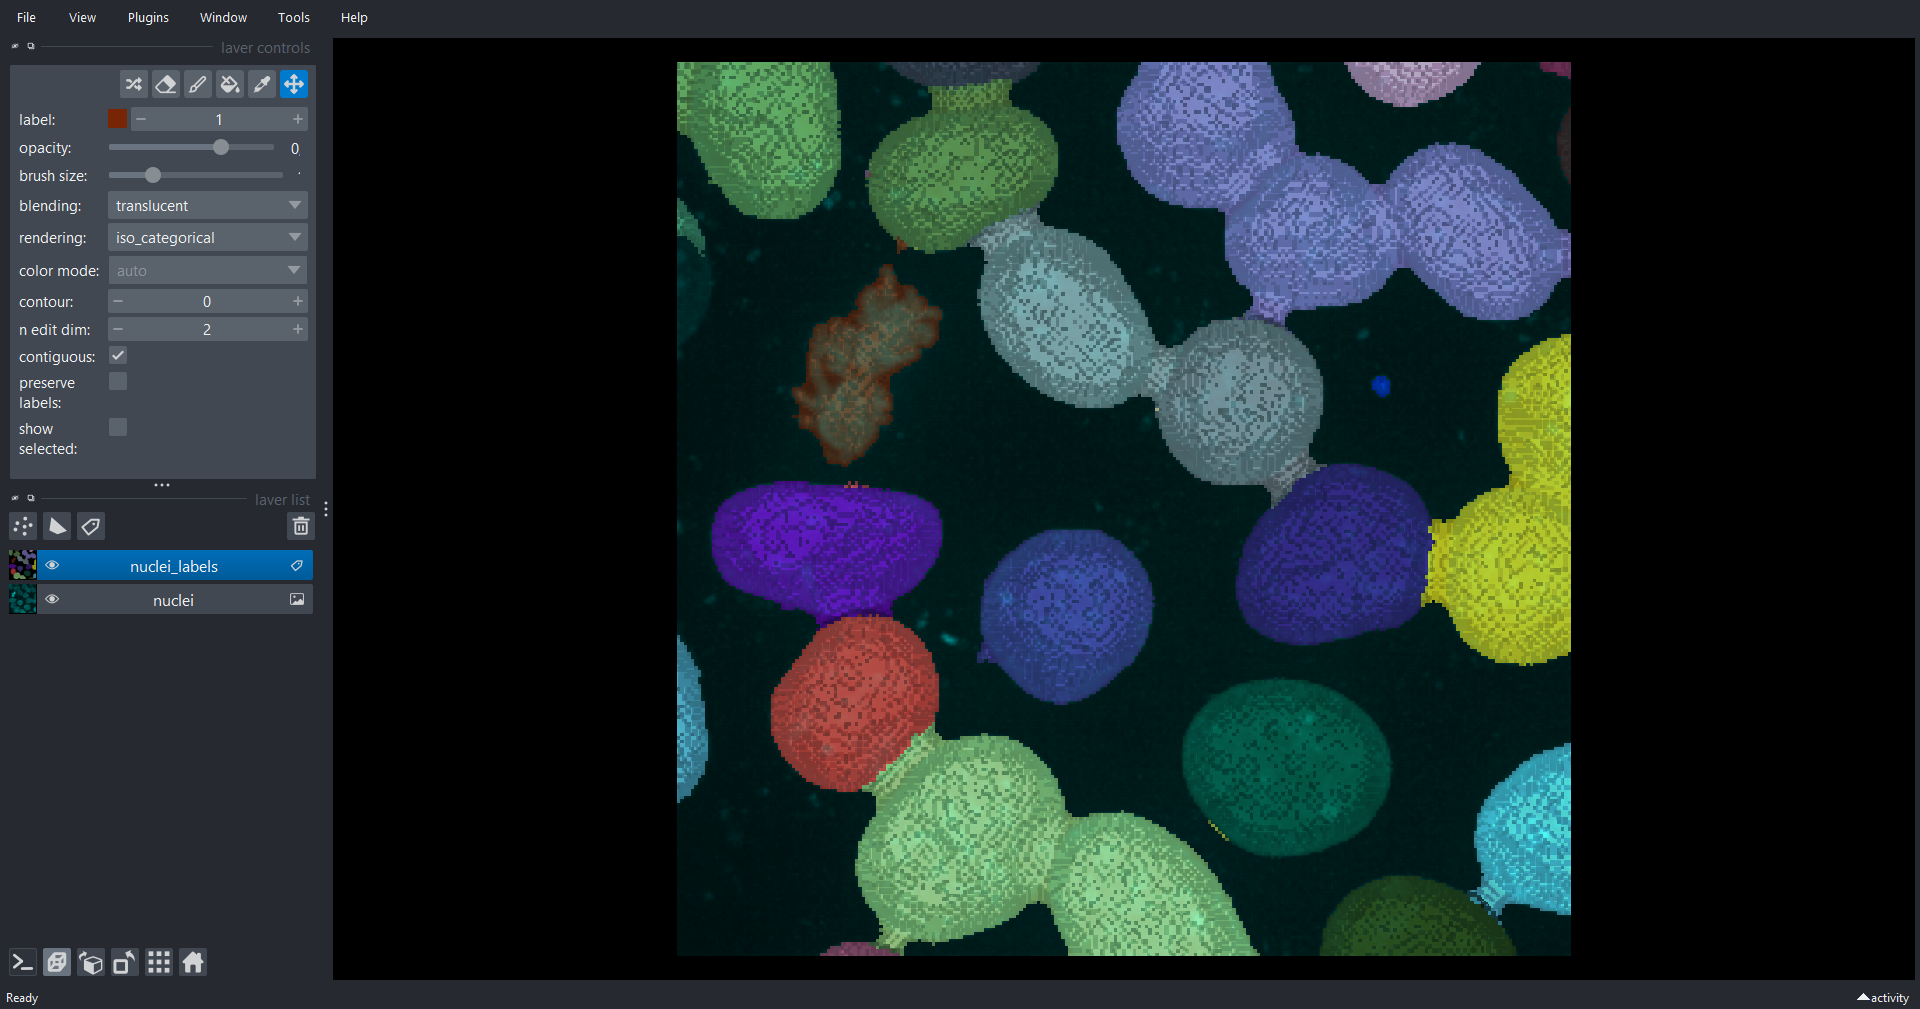

In [6]:
viewer.layers.clear()
viewer.add_image(nuclei, name='nuclei', colormap='cyan')
viewer.add_labels(labeled, name='nuclei_labels')
napari.utils.nbscreenshot(viewer)

Again, we quickly upload the image to OMERO so that we can attach the ROIs to it later:

In [7]:
# we first need to upload the image:
image_id = ezomero.post_image(conn, image=image[None, :], image_name='cells3d', dim_order='tzcyx')

In [8]:
image_wrapper, metadata = ezomero.get_image(conn, image_id, dim_order='tczyx', no_pixels=True)
updateService = image_wrapper._conn.getUpdateService()

We now need to iterate over each label and for each label, over every z-slice. In each slice we check whether the selected label actually extends into this slice. We then throw the binary mask of this label in this slice into the very convenient `omero_rois.mask_from_binary_image` function. At this point we can directly pass the `T/C/Z` information to the shape object. We then add this shape to a ROI, which is comprised out of many individual shapes and upload to OMERO.

In case the actual label is somehow of importance to us, we can pass the label to the uploaded ROI. To make the display on OMERO a bit nicer, we give each ROI (i.e., each object) a random color and make it slightly opaque.

In [9]:
for label in tqdm.tqdm(range(1, labeled.max() + 1), desc='uploading ROIs'):
    roi = RoiI()
    roi.setImage(image_wrapper._obj)
    for z in range(labeled.shape[0]):
        binary = labeled[z] == label
        if not binary.any():
            continue
        random_color = (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255), 128)
        shape = omero_rois.mask_from_binary_image(binary, raise_on_no_mask=False, z=z, c=1, t=0, rgba=random_color,
                                                  text='label {}'.format(label))
        roi.addShape(shape)
    updateService.saveAndReturnObject(roi)

uploading ROIs: 100%|██████████| 34/34 [00:02<00:00, 15.52it/s]


If we introspect our data now on OMERO, this is what we get as a result:

![](./imgs/ROI_omero_3d_labels.png)

If we look closer, we can see that each individual ROI can be unfolded into all the individual 2D ROIs which make up the whole object. We can also see that each of the individual ROI layers is attributed to a specific timepoint, channel and z-slice:

![](./imgs/ROI_group_on_OMERO.png)